In [1]:
pip install python-dateutil



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta



# Get sp500 tickers

In [2]:
url='https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables=pd.read_html(url)
tables

[    Symbol             Security             GICS Sector  \
 0      MMM                   3M             Industrials   
 1      AOS          A. O. Smith             Industrials   
 2      ABT  Abbott Laboratories             Health Care   
 3     ABBV               AbbVie             Health Care   
 4      ACN            Accenture  Information Technology   
 ..     ...                  ...                     ...   
 498    XYL           Xylem Inc.             Industrials   
 499    YUM          Yum! Brands  Consumer Discretionary   
 500   ZBRA   Zebra Technologies  Information Technology   
 501    ZBH        Zimmer Biomet             Health Care   
 502    ZTS               Zoetis             Health Care   
 
                                 GICS Sub-Industry    Headquarters Location  \
 0                        Industrial Conglomerates    Saint Paul, Minnesota   
 1                               Building Products     Milwaukee, Wisconsin   
 2                           Health Care 

In [3]:
#vogliamo solo la prima tabella

tablesp500=tables[0]
tablesp500
# ora prendiamo i ticker 
tickers=tablesp500['Symbol'].tolist()
print(tickers)


['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', '

# Create Algorithm Logic

- **Mean Reversion + Momentum:**
  - `WHEN Low < Bollinger Band Lower AND (RSI < 30 OR MFI < 20) THEN "BUY"`
  - `WHEN High > Bollinger Band Upper AND (RSI > 70 OR MFI > 80) THEN "SELL"`

---

- **How to Calculate Bollinger Bands?**  
  - Definition: "to provide a relative definition of high and low prices of a market. By definition, prices are high at the upper band and low at the lower band."  
    [https://en.wikipedia.org/wiki/Bollinger_Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)

$$
EMA_t = \alpha \times (Close_t - EMA_{t-1}) + EMA_{t-1}
$$

$$
\text{Upper Band} = \text{Middle Band EMA} + (n \times \text{Standard Deviation})
$$

$$
\text{Lower Band} = \text{Middle Band EMA} - (n \times \text{Standard Deviation})
$$

---

- **How to Calculate RSI?**  
  - Definition: "to chart the current and historical strength or weakness of a stock or market based on the closing prices of a recent trading period."  
    [https://en.wikipedia.org/wiki/Relative_strength_index](https://en.wikipedia.org/wiki/Relative_strength_index)

$$
RSI = 100 - \left( \frac{100}{1 + RS} \right)
$$

$$
\text{Where } RS = \frac{\text{Average Gain}}{\text{Average Loss}}
$$

---

- **How to Calculate Money Flow Index?**  
  - Definition: "The money flow index (MFI) is an oscillator that ranges from 0 to 100. It is used to show the money flow (an approximation of the dollar value of a day's trading) over several days."  
    [https://en.wikipedia.org/wiki/Money_flow_index](https://en.wikipedia.org/wiki/Money_flow_index)

$$
\text{typical price} = \frac{\text{high} + \text{low} + \text{close}}{3}
$$

$$
\text{money ratio} = \frac{\text{positive money flow}}{\text{negative money flow}}
$$

$$
MFI = 100 - \left( \frac{100}{1 + \text{money ratio}} \right)
$$


In [4]:
end=date.today()
start=end-relativedelta(years=5)



def bollinger_bands(df,window=20):
    df[f'SMA{window}']=df['Close'].rolling(window).mean()
    df[f'STD{window}']=df['Close'].rolling(window).std()

    df[f'Upper Band {window}']=df[f'SMA{window}']+ (df[f'STD{window}']*2)
    df[f'Lower Band {window}']=df[f'SMA{window}']- (df[f'STD{window}']*2)

    return df


def create_rsi(df,window=14):
    delta=df['Close'].diff()
    gain=(delta.where(delta>0,0))
    loss=(-delta.where(delta<0,0))
    avg_gain=gain.rolling(window=window).mean()
    avg_loss=loss.rolling(window=window).mean()
    rs=avg_gain/avg_loss
    rsi=100-(100/(1+rs))
    df['RSI']=rsi
    return df

def money_flow_index(df,window=14):
    typical_price=(df['High']+df['Low']+df['Close'])/3
    raw_money = typical_price*df['Volume']
    positive_flow= raw_money.where(typical_price>typical_price.shift(1),0) 
    negative_flow= raw_money.where(typical_price<typical_price.shift(1),0)
    positive_mf_sum=positive_flow.rolling(window=14).sum()
    negative_mf_sum=negative_flow.rolling(window=14).sum()
    money_ratio=positive_mf_sum/negative_mf_sum
    MFI= 100-(100/(1+money_ratio))
    df['MFI']=MFI
    return df


# algo logic

def algo(ticker,start=start,end=end,interval='1d'):
    df=yf.download(ticker,start=start,end=end,interval=interval)
    #df = df.xs('Close', axis=1, level=1)
    df.columns=[col[0] for col in df.columns]
    df=bollinger_bands(df=df,window=12)
    df=bollinger_bands(df=df,window=20)
    df=bollinger_bands(df=df,window=50)
    df=create_rsi(df=df,window=14)
    df=money_flow_index(df=df,window=14)
    
    #create logic for signals
    low=df['Low']
    high=df['High']
    sma12=df['SMA12']
    sma20=df['SMA20']
    sma50=df['SMA50']
    bollingerupper20=df['Upper Band 20']
    bollingerlower20=df['Lower Band 20']
    bollingerupper50=df['Upper Band 50']
    bollingerlower50=df['Lower Band 50']

    rsi=df['RSI']
    mfi=df['MFI']
    buy_signal=[]
    sell_signal=[]
    action=[]
    for i in range(len(df)):
        low_val=low.iloc[i]
        low_val = low.iloc[i]
        high_val = high.iloc[i]
        sma12_val = sma12.iloc[i]
        sma20_val = sma20.iloc[i]
        sma50_val = sma50.iloc[i]
        bollingerlowerval20 = bollingerlower20.iloc[i]
        bollingerupperval20 = bollingerupper20.iloc[i]
        bollingerlowerval50 = bollingerlower50.iloc[i]
        bollingerupperval150 = bollingerupper50.iloc[i]
        rsi_val=rsi.iloc[i]
        mfi_val= mfi.iloc[i]

        ##buy logic
        buy_condition= (low_val < bollingerlowerval20) and ( rsi_val < 30 and mfi_val < 30)
        ##sell logic
        sell_condition= (high_val > bollingerlowerval20) and ( rsi_val > 70 and mfi_val > 75)

        if buy_condition: #means if buy_ondition is true, then...
            buy_signal.append(low_val*0.95)
            sell_signal.append(np.nan)
            action.append('Buy')
        elif sell_condition:
            sell_signal.append(high_val*1.05)
            buy_signal.append(np.nan)
            action.append('Sell')
        else:
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
            action.append('Hold')

        #add the columns to the original dataframe
    df['buy signal']=buy_signal
    df['sell signal']=sell_signal
    df['action']= action

    #Backtest logic
    initial_cash=10000
    cash=initial_cash
    position=0 #initially i do not hold anything
    portfolio_value=[]

    #Buy & Hold value
    share_cost=df['Open'].iloc[0]
    num_shares=initial_cash/share_cost
    df['Buy_hold_value']=df['Close']*num_shares

    for i in range(0,len(df)):
        action=df['action'].iloc[i]
        price=df['Close'].iloc[i]

        if action == 'Buy' and cash>0:
            position=cash/price #Buy as much as we can
            cash=0 #all money are being used

        elif action == 'Sell' and position>0:
            cash=position*price
            position=0 #all stock are being sold

        elif action == 'Hold':
            pass

        portfolio_value.append(cash+position*price) #value at the end of the day


    df['Portfolio_value']=portfolio_value
    
    return df
    

In [38]:
df=algo(ticker='COIN')

[*********************100%***********************]  1 of 1 completed


In [39]:
df

,Close,High,Low,Open,Volume,SMA12,Upper Band 12,Lower Band 12,SMA20,Upper Band 20,...,SMA50,Upper Band 50,Lower Band 50,RSI,MFI,buy signal,sell signal,action,Buy_hold_value,Portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-14,328.279999,429.540009,310.000000,381.000000,81065700,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,8616.272934,10000.000000
2021-04-15,322.750000,349.200012,317.269989,348.899994,39777900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,8471.128609,10000.000000
2021-04-16,342.000000,345.989990,321.029999,327.500000,22654500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,8976.377953,10000.000000
2021-04-19,333.000000,341.010010,326.790009,337.260010,11405600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,8740.157480,10000.000000
2021-04-20,320.820007,334.829987,312.019989,333.429993,18082300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hold,8420.472633,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,256.630005,258.250000,252.399994,255.660004,6064800,255.415834,272.562305,238.269363,254.388999,281.691085,...,212.9114,287.942986,137.879813,45.874450,53.340894,NaN,NaN,Hold,6735.695666,23324.364501
2025-06-10,254.940002,262.399994,251.630005,258.880005,5858000,253.998333,267.633044,240.363622,256.774999,272.683935,...,214.5316,289.626045,139.437154,46.352516,59.487292,NaN,NaN,Hold,6691.338647,23324.364501
2025-06-11,250.679993,259.899994,249.059998,257.209991,5986100,252.958332,265.394871,240.521793,256.463999,272.604153,...,216.1006,290.865043,141.336156,45.391019,52.170902,NaN,NaN,Hold,6579.527367,23324.364501


### Visualize Algorithm

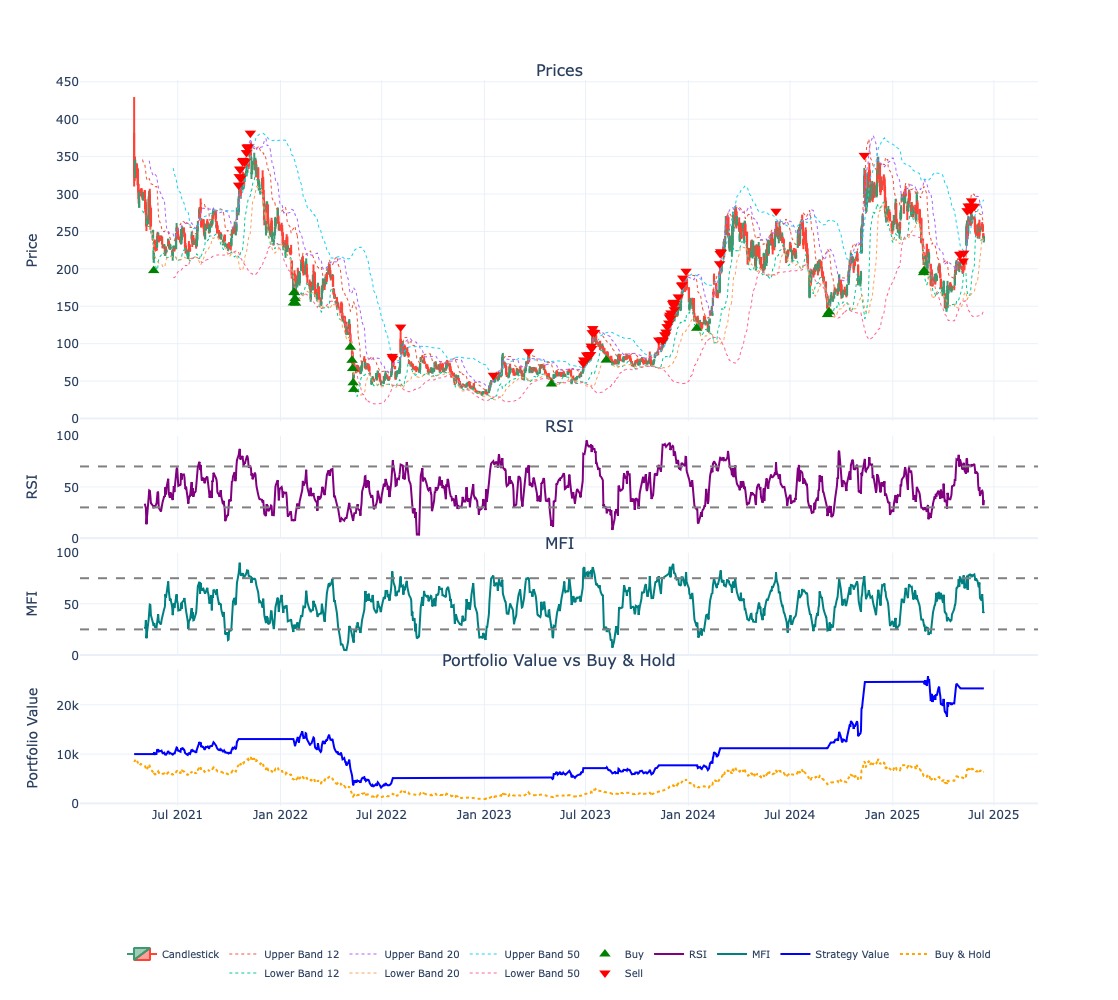

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    row_heights=[0.5, 0.15, 0.15, 0.2],
    subplot_titles=["Prices", "RSI", "MFI", "Portfolio Value vs Buy & Hold"]
)

fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'],
    name='Candlestick'
), row=1, col=1)


for window in [12, 20, 50]:
    fig.add_trace(go.Scatter(
        x=df.index, y=df[f'Upper Band {window}'],
        line=dict(width=1, dash='dot'),
        name=f'Upper Band {window}', legendgroup=f'bb{window}', showlegend=True
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=df.index, y=df[f'Lower Band {window}'],
        line=dict(width=1, dash='dot'),
        name=f'Lower Band {window}', legendgroup=f'bb{window}', showlegend=True
    ), row=1, col=1)


fig.add_trace(go.Scatter(
    x=df.index, y=df['buy signal'],
    mode='markers', name='Buy',
    marker=dict(symbol='triangle-up', color='green', size=10),
    legendgroup='signals', showlegend=True
), row=1, col=1)


fig.add_trace(go.Scatter(
    x=df.index, y=df['sell signal'],
    mode='markers', name='Sell',
    marker=dict(symbol='triangle-down', color='red', size=10),
    legendgroup='signals', showlegend=True
), row=1, col=1)


fig.add_trace(go.Scatter(
    x=df.index, y=df['RSI'],
    line=dict(color='purple'), name='RSI'
), row=2, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="gray", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="gray", row=2, col=1)


fig.add_trace(go.Scatter(
    x=df.index, y=df['MFI'],
    line=dict(color='teal'), name='MFI'
), row=3, col=1)
fig.add_hline(y=75, line_dash="dash", line_color="gray", row=3, col=1)
fig.add_hline(y=25, line_dash="dash", line_color="gray", row=3, col=1)


fig.add_trace(go.Scatter(
    x=df.index, y=df['Portfolio_value'],
    line=dict(color='blue'), name='Strategy Value'
), row=4, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['Buy_hold_value'],
    line=dict(color='orange', dash='dot'), name='Buy & Hold'
), row=4, col=1)

fig.update_layout(
    height=1000,
    
    xaxis_rangeslider_visible=False,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.25,  # sposta la legenda sotto il grafico
        xanchor='center',
        x=0.5,
        font=dict(size=10)
    ),
    margin=dict(t=80, b=100),  # margini top e bottom
    template='plotly_white'
)

fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='RSI', row=2, col=1, range=[0, 100])
fig.update_yaxes(title_text='MFI', row=3, col=1, range=[0, 100])
fig.update_yaxes(title_text='Portfolio Value', row=4, col=1)

fig.show()



# Stock Screener
### Filter stocks which has good consensus and outperfomed with the algorithm 

In [8]:
result_dict={}
for ticker in tickers:
    try:
        ticker=ticker.replace('.','-')
        print(f'>> running {ticker}')
        df=algo(ticker=ticker,start=start,end=end,interval='1d')
        #get wall street consensus:
        stock=yf.Ticker(ticker)
        analyst_ratings=stock.recommendations
        analyst_ratings=analyst_ratings[(analyst_ratings['period']=='0m')]
        count_buy= analyst_ratings['strongBuy']+analyst_ratings['buy']
        count_buy=count_buy[0]
        count_sell= analyst_ratings['strongSell']+analyst_ratings['sell']
        count_sell=count_sell[0]
        analyst_ratings['IsMoreBuys']=['Y' if a > b else 'N'  for a,b in zip(analyst_ratings['strongBuy']+analyst_ratings['buy'] , analyst_ratings['strongSell']+analyst_ratings['sell'])]
        result_dict[f'{ticker}']=(df['Buy_hold_value'].iloc[-1],df['Portfolio_value'].iloc[-1],count_buy,count_sell,analyst_ratings['IsMoreBuys'].iloc[-1])
    except Exception  as e :
        print(f' ERROR >> {e}')



>> running MMM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AOS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ABT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ABBV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ACN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ADBE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AMD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AES


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AFL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running A


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running APD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ABNB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AKAM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ALB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ARE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ALGN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ALLE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LNT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ALL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GOOGL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GOOG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AMZN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AMCR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AEE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AEP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AXP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AIG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AMT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AWK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AMP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AME


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AMGN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running APH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ADI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ANSS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AON


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running APA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running APO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AAPL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AMAT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running APTV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ACGL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ADM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ANET


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AJG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AIZ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running T


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ATO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ADSK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ADP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AZO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AVB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AVY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AXON


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BKR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BALL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BAC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BAX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BDX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BRK-B


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BBY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TECH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BIIB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BLK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BKNG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BSX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BMY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running AVGO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BRO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BF-B


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BLDR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running BXP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CHRW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CDNS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CZR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CPT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CPB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running COF


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CAH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KMX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CCL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CARR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CAT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CBOE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CBRE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CDW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running COR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CNC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CNP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CF


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CRL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SCHW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CHTR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CVX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CMG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CHD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CINF


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CTAS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CSCO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running C


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CFG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CLX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CME


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CMS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CTSH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running COIN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CMCSA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CAG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running COP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ED


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running STZ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CEG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running COO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CPRT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GLW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CPAY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CTVA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CSGP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running COST


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CTRA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CRWD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CCI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CSX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CMI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CVS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DHR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DRI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DVA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DAY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DECK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DELL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DAL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DVN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DXCM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FANG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DLR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DLTR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running D


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DPZ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DASH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DOV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DOW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DHI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DTE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DUK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EMN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ETN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EBAY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ECL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EIX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ELV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EMR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ENPH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ETR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EOG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EPAM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EQT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EFX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EQIX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EQR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ERIE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ESS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EVRG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ES


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EXC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EXE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EXPE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EXPD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running EXR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running XOM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FFIV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FDS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FICO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FAST


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FRT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FDX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FIS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FITB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FSLR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running F


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FTNT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FTV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FOXA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FOX


[*********************100%***********************]  1 of 1 completed


 ERROR >> HTTP Error 404: 
>> running BEN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running FCX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GRMN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GEHC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GEV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GEN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GNRC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GIS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GPC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GILD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GPN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GDDY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HAL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HIG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HAS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HCA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DOC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HSIC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HSY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HES


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HPE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HLT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HOLX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HON


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HRL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HST


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HWM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HPQ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HUBB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HUM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HBAN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running HII


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IBM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IEX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IDXX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ITW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running INCY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PODD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running INTC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ICE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IFF


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IPG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running INTU


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ISRG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IVZ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running INVH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IQV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running IRM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running JBHT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running JBL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running JKHY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running J


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running JNJ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running JCI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running JPM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running JNPR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running K


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KVUE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KDP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KEY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KEYS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KMB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KIM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KMI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KKR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KLAC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KHC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running KR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LHX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LRCX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LVS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LDOS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LEN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LII


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LLY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LIN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LYV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LKQ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LMT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running L


[*********************100%***********************]  1 of 1 completed


 ERROR >> 'period'
>> running LOW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LULU


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LYB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MTB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MPC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MKTX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MAR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MMC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MLM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MAS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MTCH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MKC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MCD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MCK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MDT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MRK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running META


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MET


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MTD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MGM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MCHP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MU


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MSFT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MAA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MRNA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MHK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MOH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TAP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MDLZ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MPWR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MNST


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MCO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MOS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MSI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running MSCI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NDAQ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NTAP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NFLX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NEM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NWSA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NWS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NEE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NKE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NDSN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NSC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NTRS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NOC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NCLH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NRG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NUE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NVDA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NVR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NXPI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ORLY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running OXY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ODFL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running OMC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ON


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running OKE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ORCL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running OTIS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PCAR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PKG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PLTR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PANW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PARA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PAYX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PAYC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PYPL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PNR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PEP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PFE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PCG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PSX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PNW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PNC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running POOL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PPG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PPL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PFG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PGR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PLD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PRU


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PEG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PTC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PSA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PHM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running PWR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running QCOM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DGX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RJF


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RTX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running O


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running REG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running REGN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RF


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RSG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RMD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RVTY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ROK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ROL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ROP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ROST


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running RCL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SPGI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running CRM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SBAC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SLB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running STX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SRE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running NOW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SHW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SPG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SWKS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SJM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SNA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SOLV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running LUV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SWK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SBUX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running STT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running STLD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running STE


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SYK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SMCI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SYF


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SNPS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running SYY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TMUS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TROW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TTWO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TPR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TRGP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TGT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TEL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TDY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TER


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TSLA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TXN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TPL


[*********************100%***********************]  1 of 1 completed


 ERROR >> 'period'
>> running TXT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TMO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TJX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TKO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TSCO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TDG


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TRV


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TRMB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TFC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TYL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running TSN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running USB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running UBER


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running UDR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ULTA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running UNP


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running UAL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running UPS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running URI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running UNH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running UHS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VLO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VTR


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VLTO


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VRSN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VRSK


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VZ


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VRTX


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VTRS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VICI


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running V


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VST


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running VMC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WRB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running GWW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WAB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WBA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WMT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running DIS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WBD


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WAT


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WEC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WFC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WELL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WST


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WDC


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WSM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WMB


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WTW


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WDAY


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running WYNN


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running XEL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running XYL


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running YUM


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ZBRA


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ZBH


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



>> running ZTS


[*********************100%***********************]  1 of 1 completed
/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/1658354319.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
df_results=pd.DataFrame.from_dict(result_dict,orient='index',columns=['Buy_hold_value','Portfolio_value','Count_Buy','Count_Sell','IsMoreBuys'])
df_results['Difference']=df_results['Portfolio_value']-df_results['Buy_hold_value']
df_results['Buy_Hold_%']=(df_results['Buy_hold_value']-10000)/10000
df_results['Strategy_%']=(df_results['Portfolio_value']-10000)/10000
df_results['Difference_%']=df_results['Strategy_%']-df_results['Buy_Hold_%']
df_buys=df_results[(df_results['IsMoreBuys']==True)&(df_results['Difference_%']>0)]
df_sorted=df_results.sort_values(by='Difference_%',ascending=True) #increasing order --> from the lowest to the highest
display(df_sorted)

,Buy_hold_value,Portfolio_value,Count_Buy,Count_Sell,IsMoreBuys,Difference,Buy_Hold_%,Strategy_%,Difference_%
PLTR,137399.993896,6249.116046,4,6,N,-131150.877851,12.739999,-0.375088,-13.115088
SMCI,140976.940362,14778.646683,6,2,Y,-126198.293678,13.097694,0.477865,-12.619829
NVDA,161581.314272,40651.466071,58,1,Y,-120929.848201,15.158131,3.065147,-12.092985
HWM,131907.425491,13665.717194,20,0,Y,-118241.708297,12.190743,0.366572,-11.824171
TRGP,107363.497704,13265.151231,21,0,Y,-94098.346473,9.736350,0.326515,-9.409835
...,...,...,...,...,...,...,...,...,...
HAL,21056.781210,33184.294615,20,0,Y,12127.513405,1.105678,2.318429,1.212751
EPAM,7425.527387,21293.222398,14,1,Y,13867.695011,-0.257447,1.129322,1.386770
OXY,28155.587265,42098.049505,8,2,Y,13942.462239,1.815559,3.209805,1.394246
HII,14754.658365,29040.176316,4,1,Y,14285.517951,0.475466,1.904018,1.428552


In [31]:

def highlight_profit(val):
    if isinstance(val, (int, float)):
        color = 'green' if val > 0 else 'red'
        return f'color: {color}'
    return ''

styled_df = df_sorted.style\
    .format({
        'Buy_hold_value': '{:,.2f}',
        'Portfolio_value': '{:,.2f}',
        'Difference': '{:,.2f}',
        'Buy_Hold_%': '{:.2%}',
        'Strategy_%': '{:.2%}',
        'Difference_%': '{:.2%}'
    })\
    .applymap(highlight_profit, subset=['Difference', 'Difference_%', 'Strategy_%', 'Buy_Hold_%'])\
    .background_gradient(subset=['Difference_%'], cmap='RdYlGn')\
    .set_caption("📊 Performance Strategia vs Buy & Hold (ordinato per Difference_%)")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [('caption-side', 'top'), ('font-size', '16px'), ('color', '#333'), ('font-weight', 'bold')]
    }])

styled_df


/var/folders/nz/hms_lrs105q9hkd35b80lq1m0000gn/T/ipykernel_4441/3932341060.py:17: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,Buy_hold_value,Portfolio_value,Count_Buy,Count_Sell,IsMoreBuys,Difference,Buy_Hold_%,Strategy_%,Difference_%,Sector
PLTR,"137,399.99","6,249.12",4,6,N,"-131,150.88",1274.00%,-37.51%,-1311.51%,Technology
SMCI,"140,976.94","14,778.65",6,2,Y,"-126,198.29",1309.77%,47.79%,-1261.98%,Technology
NVDA,"161,581.31","40,651.47",58,1,Y,"-120,929.85",1515.81%,306.51%,-1209.30%,Technology
HWM,"131,907.43","13,665.72",20,0,Y,"-118,241.71",1219.07%,36.66%,-1182.42%,Industrials
TRGP,"107,363.50","13,265.15",21,0,Y,"-94,098.35",973.63%,32.65%,-940.98%,Energy
AVGO,"95,781.97","12,092.82",37,0,Y,"-83,689.15",857.82%,20.93%,-836.89%,Technology
VST,"99,706.05","23,469.07",15,1,Y,"-76,236.98",897.06%,134.69%,-762.37%,Utilities
PWR,"101,397.94","27,026.74",20,1,Y,"-74,371.20",913.98%,170.27%,-743.71%,Industrials
AXON,"85,035.95","12,549.04",14,0,Y,"-72,486.90",750.36%,25.49%,-724.87%,Industrials
GE,"69,889.77","8,586.92",17,0,Y,"-61,302.85",598.90%,-14.13%,-613.03%,Industrials


Recupero settori da yfinance:   0%|          | 0/500 [00:00<?, ?it/s]

Exception ignored from cffi callback <function buffer_callback at 0x152911620>:
Traceback (most recent call last):
  File "/Users/alessandro/anaconda3/lib/python3.11/site-packages/curl_cffi/curl.py", line 67, in buffer_callback
    @ffi.def_extern()
    
KeyboardInterrupt: 


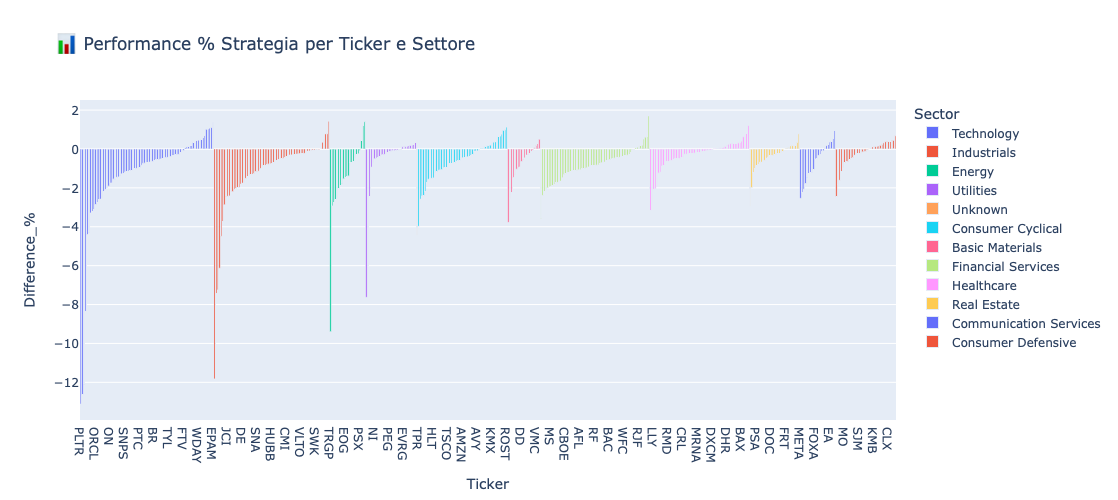

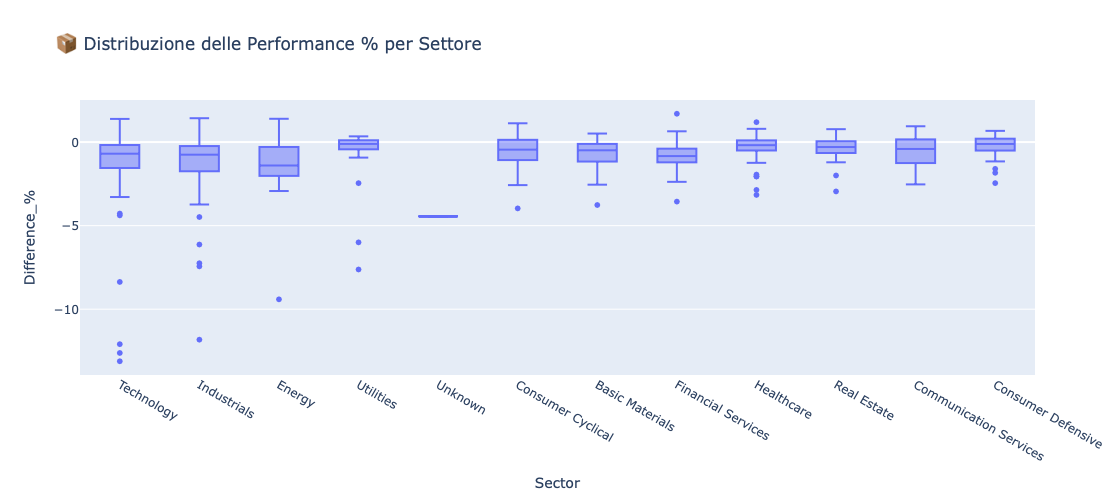

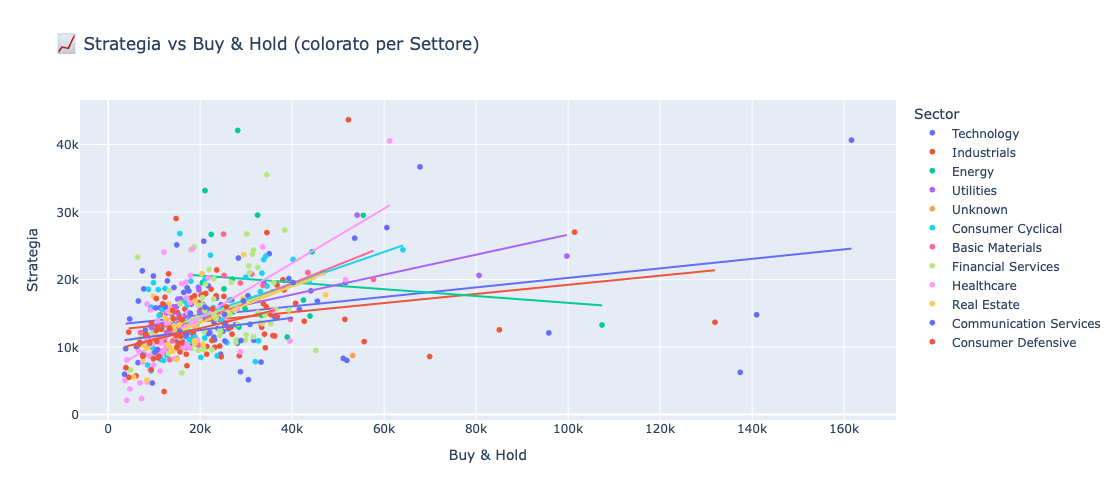

In [32]:
import yfinance as yf
import plotly.express as px
import pandas as pd
from tqdm.notebook import tqdm


df_sorted = df_sorted.copy()  # sicurezza


sectors = []
for ticker in tqdm(df_sorted.index, desc="Recupero settori da yfinance"):
    try:
        info = yf.Ticker(ticker).info
        sectors.append(info.get('sector', 'Unknown'))
    except:
        sectors.append('Unknown')

df_sorted['Sector'] = sectors


fig1 = px.bar(df_sorted.reset_index(),
              x='index',
              y='Difference_%',
              color='Sector',
              text='Difference_%',
              title=' Performance % Strategia per Ticker e Settore',
              labels={'index': 'Ticker'},
              height=500)


fig2 = px.box(df_sorted,
              x='Sector',
              y='Difference_%',
              title=' Distribuzione delle Performance % per Settore',
              height=500)


fig3 = px.scatter(df_sorted,
                  x='Buy_hold_value',
                  y='Portfolio_value',
                  color='Sector',
                  hover_name=df_sorted.index,
                  title=' Strategia vs Buy & Hold (colorato per Settore)',
                  labels={'Buy_hold_value': 'Buy & Hold', 'Portfolio_value': 'Strategia'},
                  height=500,
                  trendline='ols')


fig1.show()
fig2.show()
fig3.show()
